<a href="https://colab.research.google.com/github/celestial-shubham/Dog-Breed-Predictor/blob/main/dog_breed_prediction_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*

# End-To-End  multi class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

## 2. Data :
The data we're using is from kaggle's Dog breed identification competition.


## 3. Evaluaton 
The evaluation is a file with prediction probabilities for each dog breed of each test image.

## 4. Features

some information about the data:
* we're dealing with images (unstructured data) so it's probably best we use deep learning/transfer Learning.
* there are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set.(these images have labels).
* There are around 10,000+ images in the test set(these images have no labels, because have to predict them). 

### Get our Workspace ready 

* import Tensorflow
* import Tensorflow hub 
* Must ensure we're using a GPU

In [17]:
# import the Necessary tools
import tensorflow_hub as hub
import tensorflow as tf
print("TF hub version :",hub.__version__)
print("TF version:",tf.__version__)

# Check for GPU availability
print("GPU","available" if tf.config.list_physical_devices("GPU")else "not available")

TF hub version : 0.12.0
TF version: 2.5.0
GPU available


## Getting our data ready(turning into tensors)
With all machine Learning models,our data has ro be in numerical format .So that's what we'll be doing first .Turning our images into tensors (numerical representations).

 Let's start by accessing our data and checking out the labels.

In [18]:
# Checkout the labels of our data  
import pandas as pd
labels_csv = pd.read_csv("/content/drive/My Drive/Dog breed prediction/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     146c249bf2d60bf30c309341020bf2ee  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [19]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


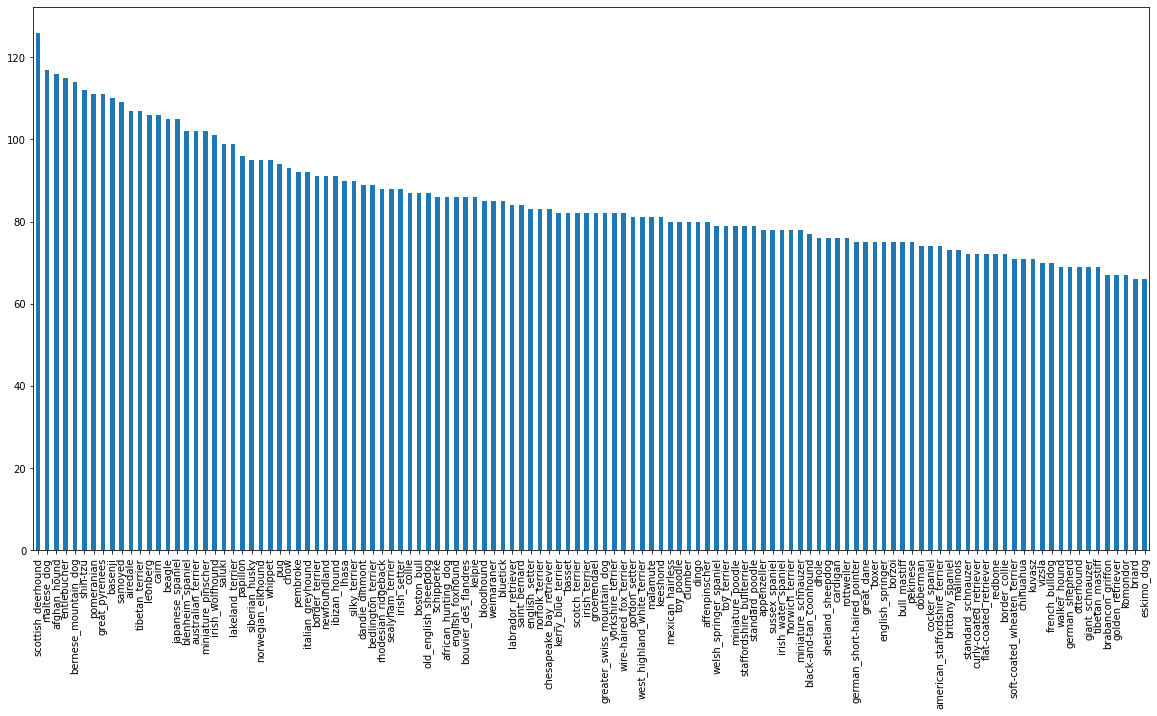

In [20]:
# How many are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [21]:
labels_csv["breed"].value_counts().median()

82.0

In [22]:
# !pip install ipython
# import IPython

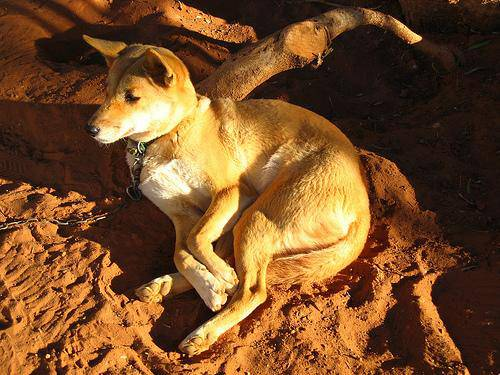

In [23]:
# Let's view an image
from IPython.display import display,Image
Image("/content/drive/My Drive/Dog breed prediction/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels 
* Let's get a list of all of our file pathnames

In [24]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [25]:
# Create pathnames from image ID's
filenames = ['/content/drive/My Drive/Dog breed prediction/train/'+fname+'.jpg' for fname in labels_csv['id']]

filenames[:10] # First 10

['/content/drive/My Drive/Dog breed prediction/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/My Drive/Dog breed prediction/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [26]:
# Check whether number of file names matches number of actual image files
import os 
if len(os.listdir("/content/drive/My Drive/Dog breed prediction/train/"))== len(filenames):
  print("proceed!!!")
else:
  print("error occured!!!")  

proceed!!!


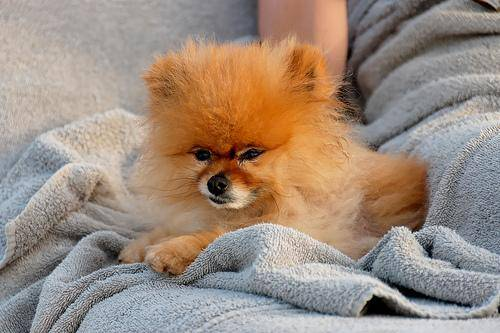

In [27]:
#one more check
Image(filenames[8000])

In [28]:
labels_csv["breed"][8000]

'pomeranian'

Since we've our training image filepaths in a
list ,Let's prepare our labels.

In [29]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
#labels= np.array(labels) # does same thing as above command
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [30]:
len(labels)

10222

In [31]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("number of labels matches number of filenames !")
else:
  print("number of labels does not match number of filenames,check data dictionaries !")  

number of labels matches number of filenames !


In [32]:
# Find the unique labels values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [33]:
unique_breeds
textfile = open("breeds.txt", "w")
for element in unique_breeds:
    textfile.write(element + "\n")
textfile.close()


In [34]:
len(unique_breeds)

120

In [35]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [36]:
# turn every labels into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [37]:
len(boolean_labels)

10222

In [38]:
# Example Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where labels occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [39]:
print(labels[2])
print(boolean_labels[2].argmax())
print(boolean_labels[2].astype(int))

pekinese
85
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own Validation set
Since the dataset from kaggle doesn't have validation set,So we will make our own.

In [40]:
# Setup x,y variables
x =filenames
y =boolean_labels

In [41]:
len(filenames)

10222

#### we're going to  start with  ~1000 images and increase as needed

In [42]:
 # Set  numbers of images to use for experimenting 
 Num_images = 10000 #@param{type : "slider" ,min :1000 ,max :10000,step :1000}

In [43]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# split them into training and validation of total size Num_images
x_train,x_val,y_train,y_val = train_test_split(x[:Num_images],
                                               y[:Num_images],
                                                test_size =0.2,
                                               random_state =42)

len(x_train) ,len(y_train) ,len(x_val) ,len(y_val)

(8000, 8000, 2000, 2000)

In [44]:
# Let's have look at our training and test data
x_train[:2],y_train[:2]

(['/content/drive/My Drive/Dog breed prediction/train/e86be20abe3ab746179728fa6f19bc59.jpg',
  '/content/drive/My Drive/Dog breed prediction/train/269a6aeefd8050aafda02044c9cd2a80.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False

## Preprocessing Images(turning images into Tensors)

To preprocess our images into tensors we're going to write a function which does a few thing:
1. Take an image filepath as input.
2. Use Tensorflow to read the file and save it to a variable,'image'
3. Turn our 'image' (a JPG)  into Tensors.
4. Normalize our image(convert color channel values from 0-255 to 0-1).
5. Resize the 'image' to be shape of(224,224).
6. Return the modified 'image'


##### before we move ahead ,Let's see what importing images looks like .


In [45]:
# convert image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [46]:
image [:3]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]]], dtype=uint8)

In [47]:
image.max(),image.min()# combination of RGB can vary from 0-255

(255, 0)

In [48]:
#turn images into  tensors
tf.constant(image)[:2]# Changed from array to tensors

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

#### Making  a function to  preprocess these tensors

In [49]:
# Define a image size
IMG_SIZE = 224

# Create a function to preprocess these images
def process_img(image_path):
  """
  Takes an image file path and turns the image into a Tensors.
  """
  # Read an image file 
  image = tf.io.read_file(image_path)# Reads and outputs the entire contents of the input filename.
  
  # Turn the jpeg image into numerical Tensors with 3 colour channels(red,green blue)
  image = tf.image.decode_jpeg(image,channels =3)

  # Convert the colour channel value from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to our desired value(224,224)
  image = tf.image.resize(image , size =[IMG_SIZE,IMG_SIZE])#Resize images to size using the specified method.Resized images will be distorted if their original aspect ratio is not the same as size.

  return image

### Turning our data into batches

Why turn our data into batches ?

Let's say we are trying to process 10,000+ images in one go... They all might not fit into memory.

So that's why we do about 32 this is (batch size) images at a time (you can manually adjust the batch size if need be). 


In order to use Tensorflow effectively,we need our data in the form of tensors tuples which look loke this:
`(image ,label)`. 


In [50]:
# Create a function to  return a tuple of tensors `(image,label)`
def get_image_label(image_path,label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of(image, label)
  """
  image = process_img(image_path)
  return image,label

In [51]:
# implementation of above code
(process_img(x[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've gota way to turn our data into tuples of tensors in the form :`(image,label)`,let's make a function to turn all of our data (`X`& `Y`) into batches.

In [52]:
# Define the batch size ,32 is great
BATCH_SIZE = 32

# create a function to turn data into batches

def create_data_batch(X,Y=None,batch_size = BATCH_SIZE,valid_data =False,test_data = False):
  """
  Creates batches of data out of image (X) and label(Y) pairs.
  shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset,we probably don't have labels

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))# only filepaths (no labels)
    #Creates a Dataset whose elements are slices of the given tensors.
    # The given tensors are sliced along their first dimension. This operation
    # preserves the structure of the input tensors, removing the first dimension
    # of each tensor and using it as the dataset dimension. All input tensors
    # must have the same size in their first dimensions.
    data_batch = data.map(process_img).batch(BATCH_SIZE)#Combines consecutive elements of this dataset into batches.
    #ex : dataset = tf.data.Dataset.range(8)
    #     dataset = dataset.batch(3)
    #     list(dataset.as_numpy_iterator())
    # ans :[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])] 
    return data_batch


  # if the data is a valid dataset, we don't need to  shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),# Filepaths labels
                                                tf.constant(Y)))# labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating Training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y)))

    # shuffle the filepathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X))

    # CReate (image,label) tuples (this also turns tha image path into a preprocessed image )
    data = data.map(get_image_label)                                              

    # Turn  the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [53]:
# Creating training and validation data batches
train_data = create_data_batch(x_train,y_train)
val_data = create_data_batch(x_val,y_val,valid_data=True)


Creating Training data batches...
Creating validation data batches...


In [54]:
# Check out the different attributes of our data batches
train_data.element_spec,val_data.element_spec #The type specification of an element of this dataset.

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing DAta Batches

* Our data is now in batches, however,these can be a little hard to understand/comprehend,let's viaualize them!!

In [55]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a Data Batch
def show_25_img(images,labels):
  """
  Display a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10,10))

  # loop through 25 for displaying 
  for i in range(25):
    # Create subplots (5 rows ,5 columns)
    ax = plt.subplot(5,5,i+1)# (rows,colm,indx)
    # Display an image
    plt.imshow(images[i])

    #Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])

    # turn the grid lines off
    plt.axis("off")


In [56]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [57]:
train_img,train_labels=next(train_data.as_numpy_iterator())
#train_img ,train_labels

In [58]:
len(train_img) ,len(train_labels)

(32, 32)

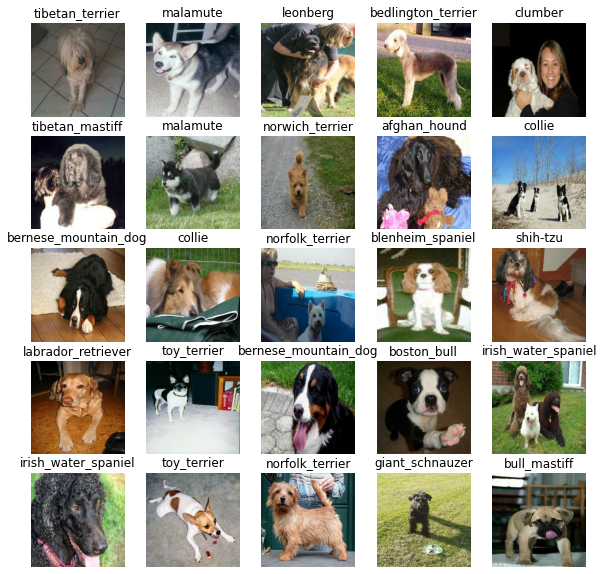

In [59]:
# Now let's visualise the data in a training batch
show_25_img(train_img,train_labels)

In [60]:
#Now let's visualize our validation set
val_img ,val_labels = next(val_data.as_numpy_iterator())
len(val_img),len(val_labels)

(32, 32)

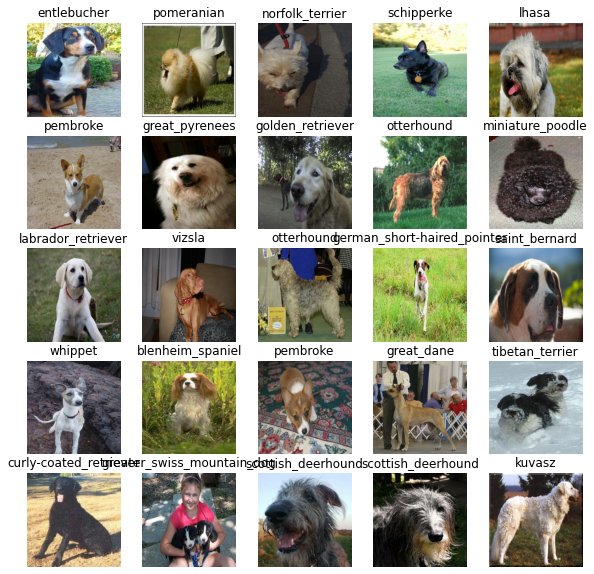

In [61]:
show_25_img(val_img,val_labels)

### Building a model

* Before we build a model, there are few things we need to define :
1. the input shape (our image shape,in the form of tensors) to our model
2. the output shape( image labels ,in the form of tensors) of our model.
3. The URL of the model we wnat to use from Tensorflow hub ~ https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [62]:
# Setup input shape of the model

INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3] # Batch ,Height ,Width ,Colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup URL model from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


Now we've got our inputs,outputs and model ready to go.
Let's put them togther into keras deep learning model.

Knowing this,Let's create a function which: 
* Takes the input shapes,output shape and the model we've chosen as parameters.
* Defines the layers in a keras model in sequential fashion.
* Compiles the model (says it should be evaluated and improved).
* Builds the model(tells the model the input shape it'll be getting).
* Returns the model 

In [63]:
  # Create a function which builds a keras model
  def create_model(input_shape = INPUT_SHAPE,output_shape= OUTPUT_SHAPE,url = MODEL_URL):
    print("Building model with:",url)

    # Setup the model layers
    model = tf.keras.Sequential([
                                 hub.KerasLayer(MODEL_URL),# Layer 1 (input_layer)
                                 tf.keras.layers.Dense(units = OUTPUT_SHAPE
                                                       ,activation = "softmax")# Layer 2(output layer)

    ])

    # Compile the model 
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [64]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


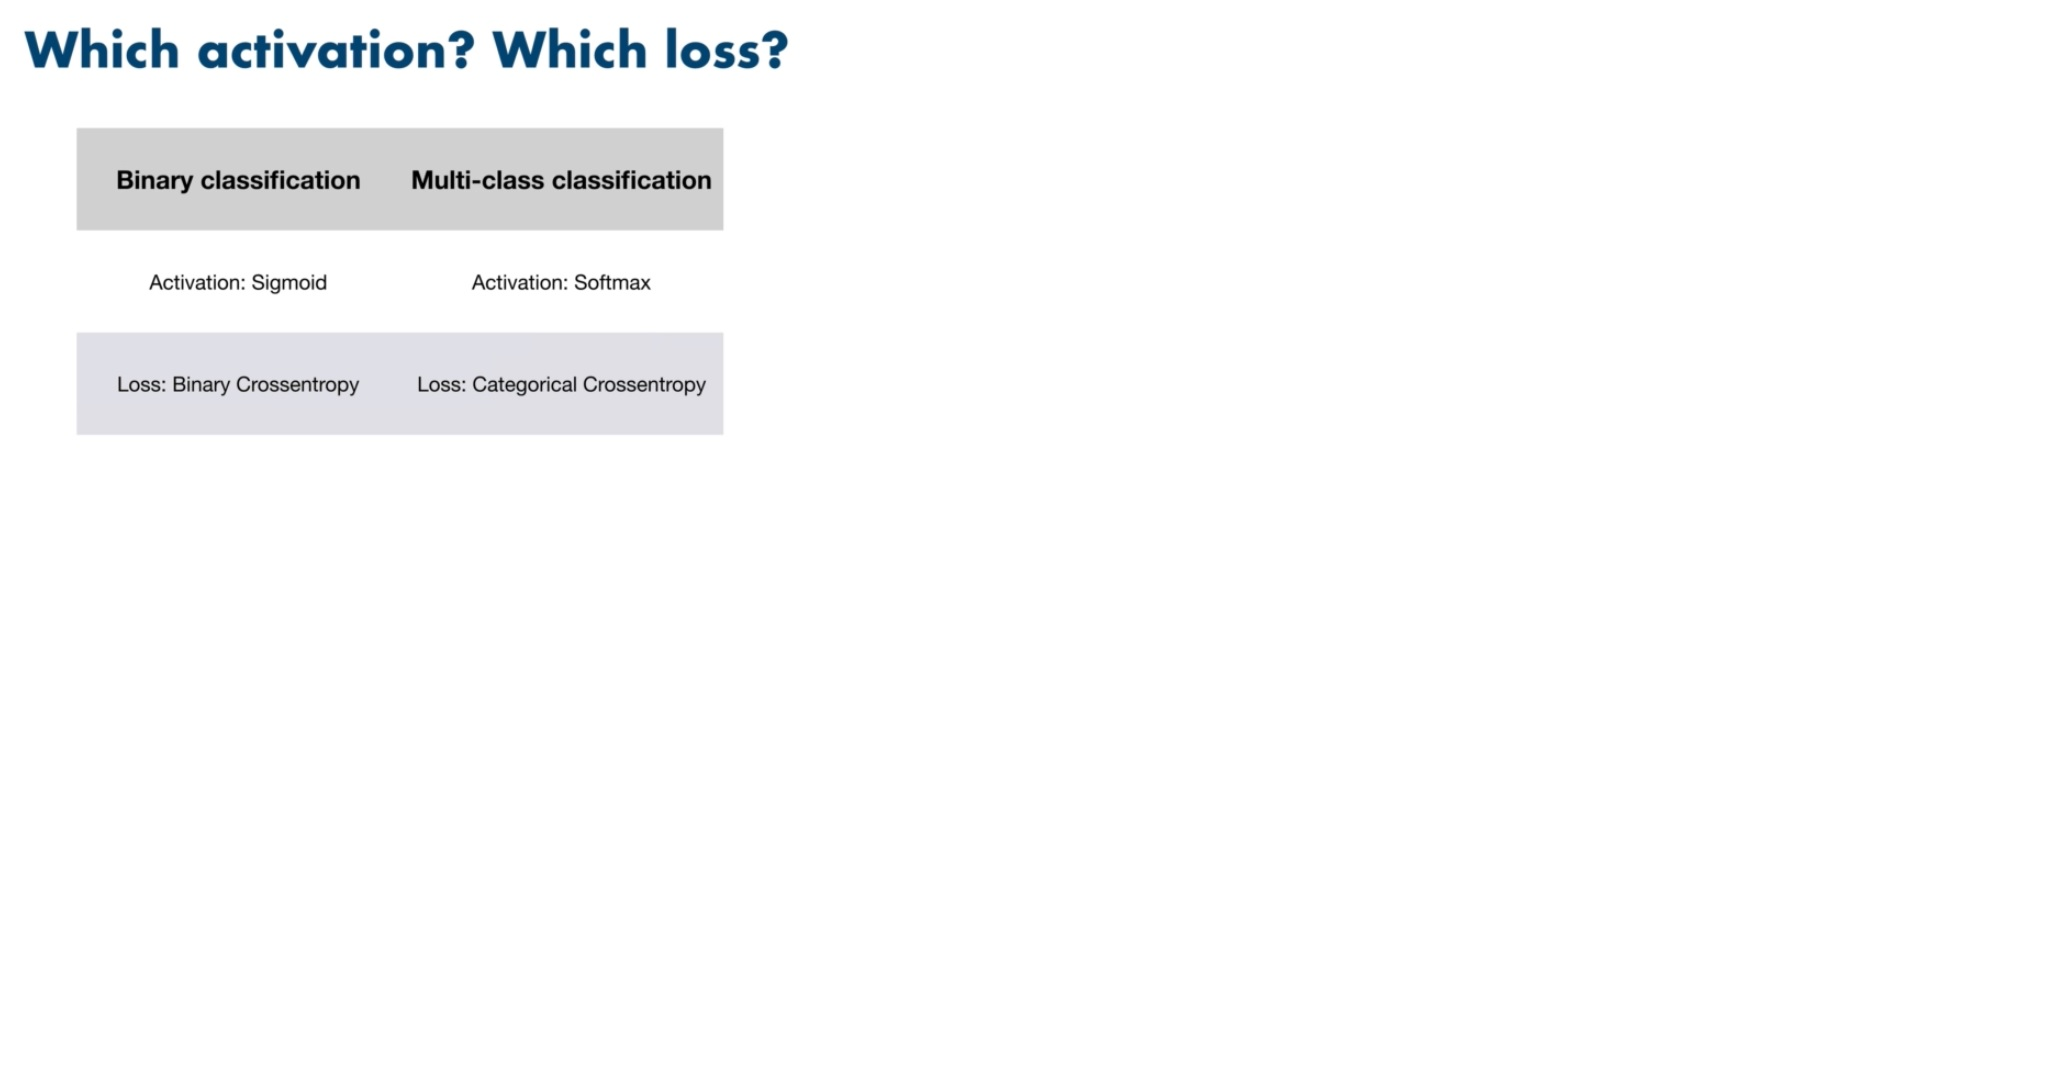

## Creating Callbacks
callbacks are helper functions a model can use during training to do such things as save its progress,  check its progress or stop training early if a model stops improving.

We'll create two callbacks,one for Tensorboard which helps track our models progress and another for early stoping which prevents our model from training for too long.

### Tensorboard Callbacks

To Setup a Tensorboard callback ,we need to do 3 things:
1. Load the Tensorboard notebook extensions.
2. Create Tensorboard callback which is a able to save logs to a directory and pass it to our model's `fit()` function. 
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training). 

In [65]:
# Load Tensorboard notebook extensions
%load_ext tensorboard 

In [66]:
import datetime

# Create a fuction to build a Tesorboard Callabck
def create_tensorboard_callback():
  # Create a log directory for storing Tensorboard logs
  logdir = os.path.join("/content/drive/My Drive/Dog breed prediction/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping Callbacks 
Early stopping helps our model to stop overfitting by stopping training if a certain evaluation metric stop improving.
 


In [67]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                              patience=3)

### Training a model

our first model is only going to train on 1000 images , to make sure everything is working.

In [68]:
NUM_EPOCHS  = 100 #@param {type:"slider",min : 10 ,max :100,steps:10}


In [ ]:
print("GPU","available!!" if tf .config.list_physical_devices("GPU") else "not available !!")

GPU available!!


### Creating function which trains a model 
1. Create a model using create_model()
2. Setup a Tensorboard callback using create_tensorboard_callback()
3. Call the `fit()` function on our model passing it the training data, validation data,number of epochs to train for(NUM_EPOCHS) and the callbacks we'd like to use .
4. Return the model. 

In [69]:
def train_model():
  # Create a model 
  model = create_model()

  # Create new Tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data, 
            epochs = NUM_EPOCHS,
            verbose = 1,
            validation_data = val_data,
            validation_freq = 1,
            callbacks =[tensorboard,early_stop])
  return model


In [ ]:
# Fitting the model to the data
model = train_model()
 

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
250/250 [==============================] - 6844s 27s/step - loss: 2.6083 - accuracy: 0.4515 - val_loss: 0.7199 - val_accuracy: 0.7820
Epoch 2/100
250/250 [==============================] - 60s 241ms/step - loss: 0.3906 - accuracy: 0.8935 - val_loss: 0.6555 - val_accuracy: 0.7980
Epoch 3/100
250/250 [==============================] - 56s 222ms/step - loss: 0.2142 - accuracy: 0.9490 - val_loss: 0.6637 - val_accuracy: 0.8015
Epoch 4/100
250/250 [==============================] - 57s 229ms/step - loss: 0.1351 - accuracy: 0.9749 - val_loss: 0.6598 - val_accuracy: 0.7965
Epoch 5/100
250/250 [==============================] - 59s 237ms/step - loss: 0.0851 - accuracy: 0.9896 - val_loss: 0.6787 - val_accuracy: 0.8025
Epoch 6/100
250/250 [==============================] - 59s 237ms/step - loss: 0.0656 - accuracy: 0.9919 - val_loss: 0.6732 - val_accuracy: 0.7990
Epoch 7/100
250/250 [==========

### Checking the tensorboard logs

The Tensorboard magic function(`%tensorboard%`) will access the logs  directory which is created earlier and visualize its contents.

In [ ]:
 %tensorboard --logdir "/content/drive/MyDrive/Dog breed prediction/logs"

<IPython.core.display.Javascript object>

### Making and evaluating predictions using a trained model

In [ ]:
# Prediction on the validation data
preds = model.predict(val_data,verbose=1)
preds

KeyboardInterrupt: ignored

In [ ]:
preds[0]# these values(confidence intervals) are the probabilities values for a single image for a given breed label,the highest value for corresponding label will be taken as breed of that image.

array([2.52240594e-03, 1.19820284e-03, 1.63692571e-02, 2.57948390e-03,
       1.39090884e-03, 3.89751932e-03, 2.50628777e-03, 5.26159711e-04,
       3.93453194e-03, 2.96550454e-03, 2.06279103e-03, 1.70541799e-03,
       4.02298151e-03, 1.01167923e-02, 4.04590787e-03, 3.27113084e-03,
       2.62315590e-02, 4.01453041e-02, 4.16717120e-03, 5.50433323e-02,
       1.12755839e-02, 1.00199124e-02, 1.62651227e-03, 3.79870506e-03,
       1.01925933e-03, 8.49922933e-03, 8.05695658e-04, 1.80753565e-03,
       1.38614047e-03, 2.05725990e-03, 3.19798547e-03, 6.98730955e-03,
       2.99063809e-02, 6.14755962e-04, 7.09038432e-05, 3.62946349e-03,
       9.81171057e-03, 2.28709029e-03, 5.32852625e-03, 1.09724840e-02,
       1.48247951e-03, 6.15870871e-04, 4.46013222e-03, 4.33984818e-03,
       3.21652777e-02, 4.46728896e-03, 4.13480401e-03, 1.70913134e-02,
       2.35635787e-03, 1.24990894e-02, 2.14779726e-03, 1.28435902e-03,
       1.29844132e-03, 6.59308571e-04, 2.84135342e-03, 1.77273422e-03,
      

In [ ]:
np.sum(preds[0])

1.0

In [ ]:
# First Prediction
index = 42
print(preds[index])
print(f"MAX value(probability of prediction):{np.max(preds[index])}")
print(f"Sum :{np.sum(preds[index])}")
print(f"Max index : {np.argmax(preds[index])}")
print(f"Predicted Label : {unique_breeds[np.argmax(preds[index])]}")

NameError: ignored

In [ ]:
# Turning probabilities into their respective label
def get_preds_label(preds_prob):
  return unique_breeds[np.argmax(preds_prob)]


# Example:
preds_label = get_preds_label(preds[111])
preds_label   

NameError: ignored

In [ ]:
val_data
# in batch form as easy for Tensorflow to process this data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>




### Creating a function to unbatch the data 

In [ ]:
def unbatchify(data):
  images_unbatch = []
  labels_unbatch = []

  for img,lbl in data.unbatch().as_numpy_iterator():
    images_unbatch.append(img)
    labels_unbatch.append(unique_breeds[np.argmax(lbl)]) 
  return images_unbatch,labels_unbatch

# unbatch the val_data
val_img,val_labels = unbatchify(val_data)
val_img[0],val_labels[0]

(array([[[0.96884924, 0.9701885 , 0.6773138 ],
         [0.9649684 , 0.9649684 , 0.6752449 ],
         [0.97255224, 0.97255224, 0.68971497],
         ...,
         [0.94544876, 0.93533266, 0.63851905],
         [0.9122807 , 0.90027964, 0.59165734],
         [0.6266023 , 0.6167168 , 0.30141547]],
 
        [[0.9636907 , 0.9677085 , 0.69290984],
         [0.97148985, 0.97514886, 0.7090773 ],
         [0.9998248 , 0.99992114, 0.74782914],
         ...,
         [0.97280353, 0.9686894 , 0.715118  ],
         [0.9849285 , 0.99132735, 0.7000457 ],
         [0.8505023 , 0.86189073, 0.55982476]],
 
        [[0.94763345, 0.9589167 , 0.70516145],
         [0.96966976, 0.9795524 , 0.73575866],
         [0.9953722 , 0.99858195, 0.7804973 ],
         ...,
         [0.8728771 , 0.8872267 , 0.69398195],
         [0.8451019 , 0.8824005 , 0.6274633 ],
         [0.7930096 , 0.83910555, 0.5551244 ]],
 
        ...,
 
        [[0.47171637, 0.37899917, 0.3959688 ],
         [0.23060556, 0.1464493 , 0.15993

In [ ]:
get_preds_label(val_labels[0])

'affenpinscher'

#### Visualising the 
* Prediction Labels
* Validation labels(truth labels)
* validation images

Creating a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label,its predicted preobability, the truth label and the target image on a single plot.

In [ ]:
def plot_pred(pred_prob,labels,images,n):
  pred_prob, true_label , image = pred_prob[n],labels[n], images[n]

  # Get the pred label
  pred_lbl = get_preds_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])# Empty list so ticks are disabled
  # Ticks are the values used to show specific points on the coordinate axis. It can be a number or a string. Whenever we plot a graph, the axes adjust and take the default ticks. Matplotlib's default ticks are generally sufficient in common situations but are in no way optimal for every plot.


  # Change the colour of the title depending on the nature of prediction.
  if pred_lbl == true_label:
    color = "green"
  else:
    color = "red"  

  # Change plot title
  plt.title("{} {:2.0f}% {}".format(pred_lbl,
                                    np.max(pred_prob)*100,
                                    true_label),
                                     color = color)

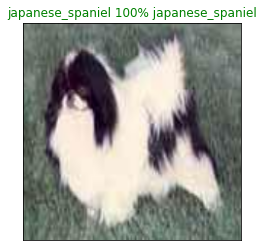

In [ ]:
plot_pred(pred_prob=preds,
          labels = val_labels,
          images = val_img,
          n =26)

NOW Visualising the top 10 predictions of our model 

In [ ]:
def plot_pred_confidences(prediction_prob,labels,n):
  pred_prob ,true_label = prediction_prob[n],labels[n]

  # Get the predicted label
  pred_label = get_preds_label(pred_prob)

  # Finding the top 10 prediction confidence indices
  top_10_indx = pred_prob.argsort()[-10:][::-1] # descending order

  # Finding the top 10 preds values
  top_10_preds = pred_prob[top_10_indx]

  # Finding top 10 labels
  top_10_labels = unique_breeds[top_10_indx]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_labels)),
                     top_10_preds,
                     color = "red")
  plt.xticks(np.arange(len(top_10_labels)),
             labels = top_10_labels,
             rotation = "vertical")
  
  # Change color of true label

  if np.isin(true_label ,top_10_labels):
    top_plot[np.argmax(top_10_labels == true_label)].set_color("green")
  else:
    pass

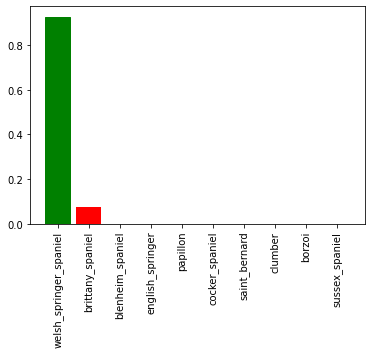

In [ ]:
  plot_pred_confidences(
      prediction_prob = preds,
      labels = val_labels,
      n = 59
  )

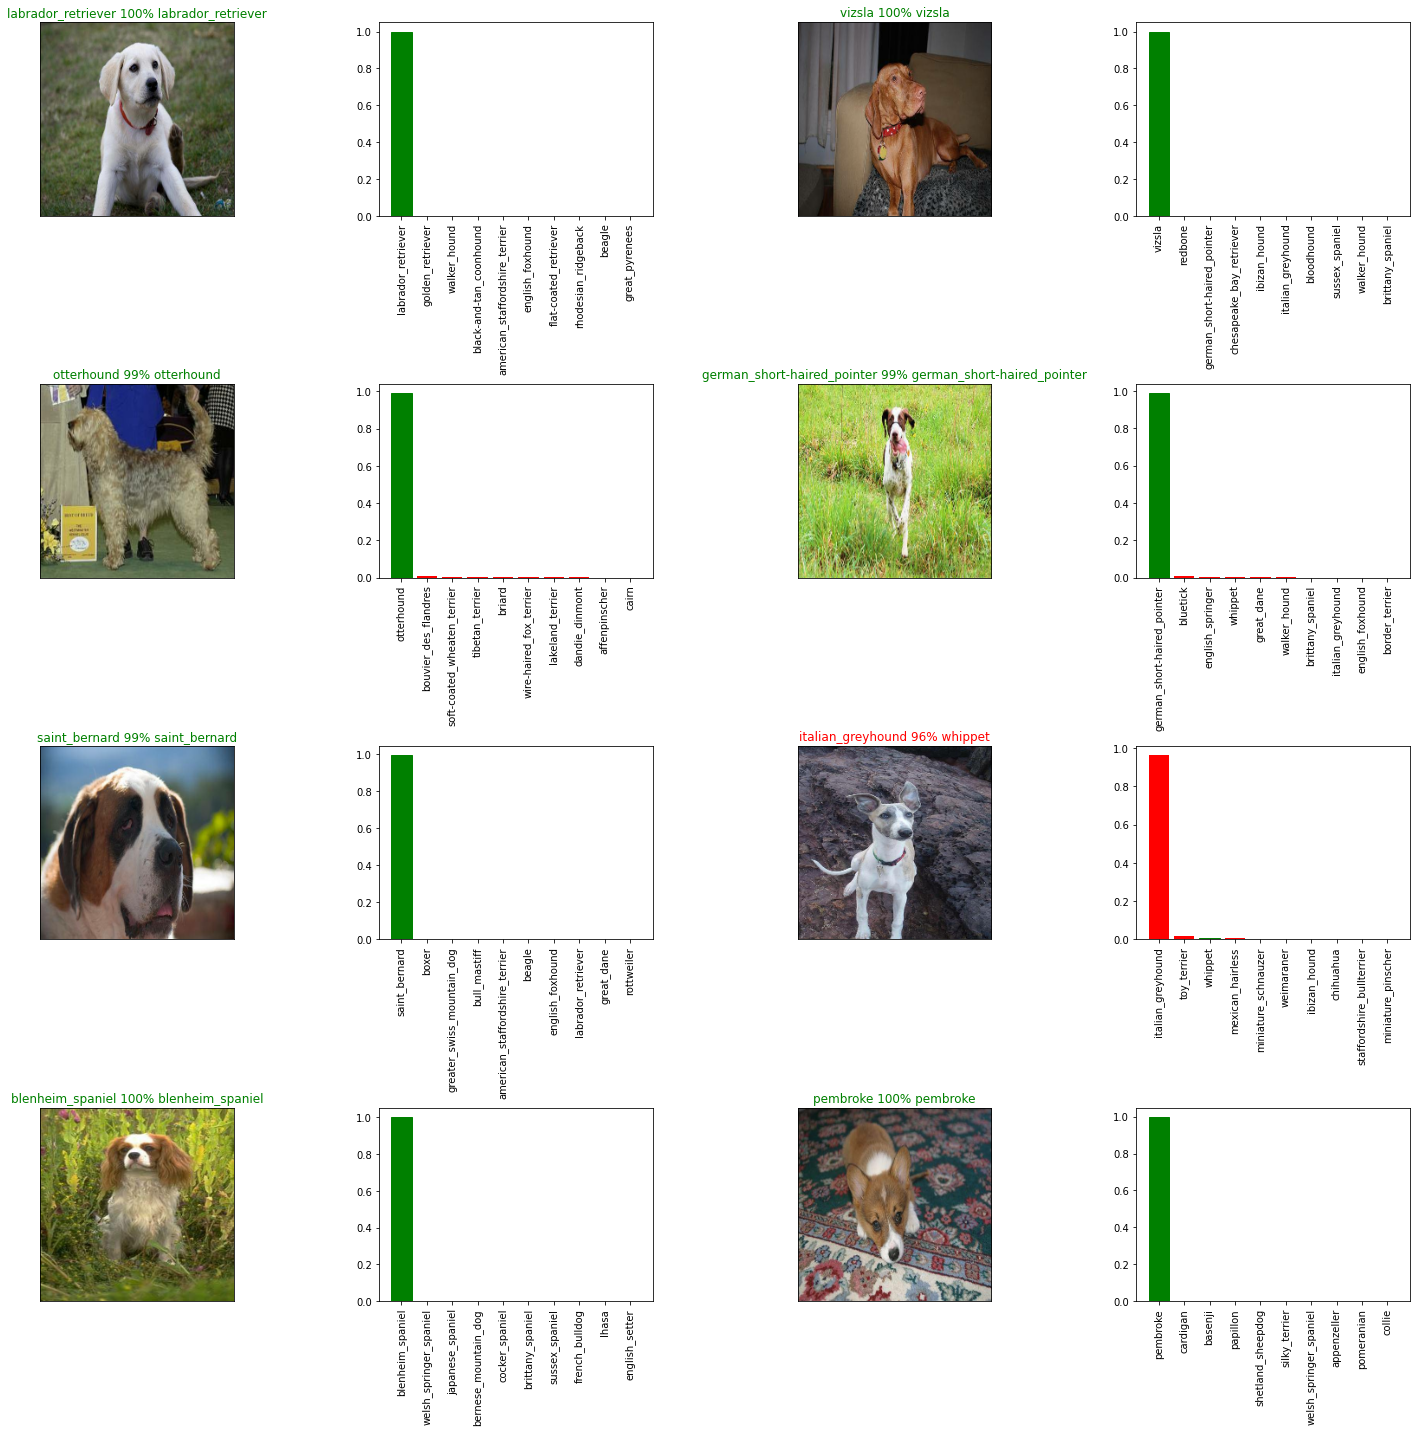

In [ ]:
# Visualising the model
i_multiplier = 10
num_rows = 4
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows,2*num_cols,2*i+1)
  plot_pred(pred_prob=preds,
            labels = val_labels,
            images = val_img,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols ,2*i+2)
  plot_pred_confidences(prediction_prob=preds,
                        labels = val_labels,
                        n = i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show()

confusion matrix with our model predictions and true labels

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


In [71]:
# i = 1;
# actual = val_labels[i]
# predicted = get_preds_label(preds[i])
# print(confusion_matrix(actual,predicted))


In [72]:
# function for Saving the model
def save_model(model , suffix = None):
  modeldir = os.path.join("/content/drive/MyDrive/Dog breed prediction/Model",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"saving model : {model_path}")
  model.save(model_path)
  return model_path

In [73]:
# function for Loading the model 
def load_model(model_path):
  print(f"loading saved model from : {model_path}")
  model = tf.keras.models.load_model(model_path,
                                      custom_objects = {"KerasLayer":hub.KerasLayer})
  return model

In [74]:
# Saving our model trained on 1000 images
save_model(model,suffix = "1000-images-mobilenetv2-Adam")

saving model : /content/drive/MyDrive/Dog breed prediction/Model/20210614-17221623691346-1000-images-mobilenetv2-Adam.h5


'/content/drive/MyDrive/Dog breed prediction/Model/20210614-17221623691346-1000-images-mobilenetv2-Adam.h5'

In [75]:
# Loading our trained model
loaded_model = load_model('/content/drive/MyDrive/Dog breed prediction/Model/20201201-09131606814037-1000-images-mobilenetv2-Adam.h5')

loading saved model from : /content/drive/MyDrive/Dog breed prediction/Model/20201201-09131606814037-1000-images-mobilenetv2-Adam.h5


## Training on full dataset

In [ ]:
len(x),len(y)

(10222, 10222)

In [ ]:
full_data =create_data_batch(x,y)

Creating Training data batches...


In [ ]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
full_model_tensorboard = create_tensorboard_callback()

# No validation set when training on all the data,so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience = 3)

In [ ]:
# Fitting model with full data

full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 209s 643ms/step - loss: 2.3644 - accuracy: 0.4900
Epoch 2/100
320/320 [==============================] - 56s 175ms/step - loss: 0.3894 - accuracy: 0.8870
Epoch 3/100
320/320 [==============================] - 54s 168ms/step - loss: 0.2224 - accuracy: 0.9423
Epoch 4/100
320/320 [==============================] - 53s 167ms/step - loss: 0.1442 - accuracy: 0.9661
Epoch 5/100
320/320 [==============================] - 53s 166ms/step - loss: 0.0942 - accuracy: 0.9835
Epoch 6/100
320/320 [==============================] - 54s 168ms/step - loss: 0.0760 - accuracy: 0.9869
Epoch 7/100
320/320 [==============================] - 55s 170ms/step - loss: 0.0564 - accuracy: 0.9909
Epoch 8/100
320/320 [==============================] - 54s 170ms/step - loss: 0.0426 - accuracy: 0.9949
Epoch 9/100
320/320 [==============================] - 54s 169ms/step - loss: 0.0398 - accuracy: 0.9953
Epoch 10/100
320/320 [==============================] - 54s 167

In [ ]:
save_model(full_model,suffix = "full-image-set-mobilenetv2-Adam")

saving model : /content/drive/MyDrive/Dog breed prediction/Model/20210127-18311611772318-full-image-set-mobilenetv2-Adam.h5


'/content/drive/MyDrive/Dog breed prediction/Model/20210127-18311611772318-full-image-set-mobilenetv2-Adam.h5'

In [76]:
loaded_full_model = load_model("/content/drive/MyDrive/Dog breed prediction/Model/20201214-13301607952655-full-image-set-mobilenetv2-Adam.h5")

loading saved model from : /content/drive/MyDrive/Dog breed prediction/Model/20201214-13301607952655-full-image-set-mobilenetv2-Adam.h5


In [ ]:
import pickle
pickle_out = open("doggo.pkl", mode = "wb") 
pickle.dump("/content/drive/MyDrive/Dog breed prediction/Model/20201214-13301607952655-full-image-set-mobilenetv2-Adam.h5", pickle_out) 
pickle_out.close()

### Making prediction on test dataset 

In [ ]:
# Loading test image filenames
test_path = "/content/drive/MyDrive/Dog breed prediction/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/Dog breed prediction/test/e73d52671c56e1507fed58c4c287d5f1.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e70dfb4bf50f74850463cfd35edc8af5.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e5560686ee44dc59dbb99d6ef4ea54d8.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e0e47873420b2ed420e920a74c663233.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e24b98741c9c780d7c5203def153f00c.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e06ce40d62d3d198f2df70349104a002.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/def88eeacc633cbc3d46d5f5fb495379.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/dd539ec1933bc47bc80b1447a26aef45.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e683ba5a138de0fbb7bb1523862b43f2.jpg',
 '/content/drive/MyDrive/Dog breed prediction/test/e7b608110b0e29120d8740f37e85f3d0.jpg']

In [ ]:
# Create test Data batch
test_data = create_data_batch(test_filenames,test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Making prediction on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                       verbose=1)
# Going to take time to train the model

324/324 [==============================] - 6890s 21s/step


In [ ]:
# To Convert Preds(numpy array) to csv files (for access later)
np.savetxt("/content/drive/MyDrive/Dog breed prediction/preds_array.csv",test_predictions,delimiter = ",")

In [ ]:
# Load preds from csv file
test_preds = np.loadtxt("/content/drive/MyDrive/Dog breed prediction/preds_array.csv",delimiter= ",")

In [ ]:
test_predictions[:10]

NameError: ignored

In [ ]:
# Making prediction on custom inputs

custom_path = "/content/drive/MyDrive/Dog breed prediction/Custom photos/"
custom_image_path = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_path

['/content/drive/MyDrive/Dog breed prediction/Custom photos/download.jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images (1).jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images (4).jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images (3).jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images (2).jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images.jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images (5).jpg',
 '/content/drive/MyDrive/Dog breed prediction/Custom photos/images (6).jpg']

In [ ]:
# Turn custom images into batch datasets
custom_data = create_data_batch(custom_image_path,test_data=True)
custom_data 

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# MAkig prediction on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
# Getting custom image  prediction labels
custom_preds_labels = [get_preds_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_labels

In [ ]:
# Our unbatchify() function won't work since there aren't labels .. 

# Getting custom images
custom_images = []

#loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

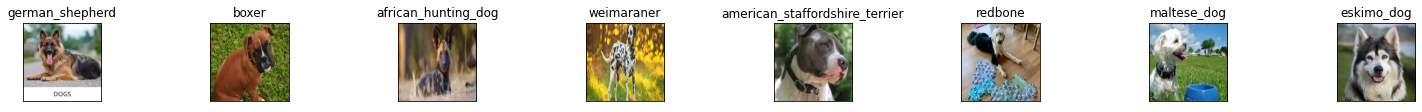

In [ ]:
plt.figure(figsize=(30,10))
for i,image in enumerate(custom_images):
  plt.subplot(1,2*9,2*i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)

In [88]:
# !pip install -q pyngrok

# !pip install -q streamlit

# !pip install -q streamlit_ace

     |████████████████████████████████| 747kB 4.4MB/s 
     |████████████████████████████████| 8.2MB 4.3MB/s 
     |████████████████████████████████| 174kB 37.4MB/s 
     |████████████████████████████████| 4.2MB 31.8MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 112kB 45.2MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 122kB 41.7MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.5.5 which is incompatible.
     |████████████████████████████████| 2.6MB 4.9MB/s 


In [133]:
%%writefile app.py
import pickle
import streamlit as st
from PIL import Image, ImageOps
from classifier import image_classification
import matplotlib.pyplot as plt
import numpy as np


# loading the trained model
st.set_option('deprecation.showfileUploaderEncoding', False)
html_temp = """
    <div style ="background-image: url("https://www.jigsawstore.com.au/assets/full/RB15633-7.jpg?20200726170018"); background-repeat: no-repeat; background-attachment: fixed; background-size: 100% 100%;} body::before{content: ""; position: absolute; top: 0px; right: 0px; bottom: 0px; left: 0px; background-color: rgba(1,2,1,0.80);">
    <div style ="background-color:tomato;padding:13px"> 
    <h1 style ="font-family:verdana;color:white;text-align:center;">DOG BREED PREDICTOR</h1> 
    </div> 
    """
# display the front end aspect
st.markdown(html_temp, unsafe_allow_html = True) 
# st.markdown('<style>body{background-image: url("https://www.jigsawstore.com.au/assets/full/RB15633-7.jpg?20200726170018"); background-repeat: no-repeat; background-attachment: fixed; background-size: 100% 100%;} body::before{content: ""; position: absolute; top: 0px; right: 0px; bottom: 0px; left: 0px; background-color: rgba(1,2,1,0.80);}</style>',unsafe_allow_html=True)
# st.markdown('<style>body{color: tomato; text-align: center;}</style>',unsafe_allow_html=True)
# st.markdown()


st.header("Upload an image of a dog to identify it's breed :dog:")

st.write("")
st.write("")
st.write("")
st.write("")
st.subheader("Choose a dog image... :dog:")
uploaded_file = st.file_uploader("", type=["jpg"])
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded image.', use_column_width=True)
    st.write("")
    with st.spinner('Identifying...'):
        label = image_classification(image,"/content/drive/MyDrive/Dog breed prediction/Model/20201214-13301607952655-full-image-set-mobilenetv2-Adam.h5")

    st.info(label)
    if st.button("About"):
        st.text("Github")
        st.text("By Shubham Verma")
        st.balloons()

Overwriting app.py


In [134]:
%%writefile classifier.py
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageOps
import numpy as np
import pickle

def image_classification(img,weights_file):
    # Get all breeds from the txt files
    with open('breeds.txt', 'r') as reader:
        breeds=[]
        for breed in reader:
            try:
                breed=breed.replace('_',' ')
                breed=breed.title()
            except:
                breed=breed.title()
            breeds.append(breed[:-1])

    # Loading the model
    def load_model(model_path):
    #print(f"loading saved model from : {model_path}")
      model = tf.keras.models.load_model(model_path,custom_objects = {"KerasLayer":hub.KerasLayer})
      return model

    model = load_model("/content/drive/MyDrive/Dog breed prediction/Model/20201214-13301607952655-full-image-set-mobilenetv2-Adam.h5")

    # Creating the array to feed into the keras model
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)
    image = img
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)

    # Turning the image into a numpy array, normalizing and loading the image
    image_array = np.asarray(image)
    normalized_image_array = (image_array.astype(np.float32)/255)
    data[0] = normalized_image_array

    # Prediction
    prediction = model.predict(data)
    return breeds[np.argmax(prediction)]

Overwriting classifier.py


In [135]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [136]:

# !unzip ngrok-stable-linux-amd64.zip

In [137]:
get_ipython().system_raw('./ngrok http 8501 &')

In [138]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://fb0569b1673c.ngrok.io


In [139]:
!streamlit run /content/app.py

2021-06-14 17:57:41.108326: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.80.53.208:8501

  Stopping...
  Stopping...
